In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import gc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


2024-10-14 18:16:01.776798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 18:16:01.855124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 18:16:01.877125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 18:16:02.061933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 18:16:03.426420: W tensorflow/compiler/tf2

In [30]:
# Custom BalancedDataGenerator class for training
class BalancedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, limit_per_label=1600):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.X[indices]
        y_batch = self.y[indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        self.indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            self.indices.extend(cls_indices)
        np.random.shuffle(self.indices)

# Custom BalancedDataGenerator class for validation (400 per class)
class BalancedValidationGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, limit_per_label=400):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.X[indices]
        y_batch = self.y[indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        self.indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            self.indices.extend(cls_indices)
        np.random.shuffle(self.indices)

# Create the Conv1D model
def create_convnet(input_shape, num_classes, 
                   num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                   kernel_size=9,
                   dense_units=[256, 256, 256, 128, 128, 128, 64, 64, 64],
                   dropout_rate=0.2,
                   padding='same'):
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=input_shape, padding=padding))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Additional convolutional layers
    for filters in num_filters[1:]:
        model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                         activation='relu', padding=padding))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Flatten the output and add dense layers
    model.add(tf.keras.layers.Flatten())

    for units in dense_units:
        model.add(tf.keras.layers.Dense(units=units, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # Optimizer and loss function
    optimizer_ = tf.keras.optimizers.AdamW(learning_rate=1e-4) 

    # Compile the model
    model.compile(optimizer=optimizer_, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Function to train the model
def train_convnet(model, train_dataset, val_dataset, limit_per_label=1600, epochs=1, batch_size=32, patience=5):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Fit the model
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    
    return history

# Function to train the model multiple times
def train_convnet_many_times(model, train_dataset, val_dataset, epochs_per_run=1, batch_size=32, num_runs=10, limit_per_label=1600):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, train_dataset, val_dataset, limit_per_label=limit_per_label, epochs=epochs_per_run, batch_size=batch_size)
        histories.append(history)
    
    return histories

# Function to print confusion matrix and classification report
def print_confusion_matrix(convnet_model, val_spectra, val_labels):   
    val_predictions = convnet_model.predict(val_spectra)
    predicted_labels = np.argmax(val_predictions, axis=1)
    true_labels = np.array(val_labels)

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Star', 'Binary Star','Galaxy', 'AGN'], yticklabels=['Star', 'Binary Star','Galaxy', 'AGN'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

: 

In [3]:
# Custom BalancedDataGenerator class for training
class BalancedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, limit_per_label=1600):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.X[indices]
        y_batch = self.y[indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        self.indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            self.indices.extend(cls_indices)
        np.random.shuffle(self.indices)

# Custom BalancedDataGenerator class for validation (400 per class)
class BalancedValidationGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, limit_per_label=400):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.X[indices]
        y_batch = self.y[indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        self.indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            self.indices.extend(cls_indices)
        np.random.shuffle(self.indices)

# Create the Conv1D model
def create_convnet(input_shape, num_classes, 
                   num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                   kernel_size=9,
                   dense_units1=256, 
                   dense_units2=128,
                   dense_units3=64,
                   dropout_rate=0.2,
                   padding='same'):
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=input_shape, padding=padding))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Additional convolutional layers
    for filters in num_filters[1:]:
        model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                         activation='relu', padding=padding))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Flatten the output and add dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=dense_units1, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Adding another dense layer
    if dense_units2:
        model.add(tf.keras.layers.Dense(units=dense_units2, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Adding another dense layer
    if dense_units3:
        model.add(tf.keras.layers.Dense(units=dense_units3, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # Optimizer and loss function
    optimizer_ = tf.keras.optimizers.AdamW(learning_rate=1e-4) 

    # Compile the model
    model.compile(optimizer=optimizer_, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Function to train the model
def train_convnet(model, train_dataset, val_dataset, limit_per_label=1600, epochs=1, batch_size=32, patience=5):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Fit the model
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    
    return history

# Function to train the model multiple times
def train_convnet_many_times(model, train_dataset, val_dataset, epochs_per_run=1, batch_size=32, num_runs=10, limit_per_label=1600):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, train_dataset, val_dataset, limit_per_label=limit_per_label, epochs=epochs_per_run, batch_size=batch_size)
        histories.append(history)
    
    return histories

# Function to print confusion matrix and classification report
def print_confusion_matrix(convnet_model, val_spectra, val_labels):   
    val_predictions = convnet_model.predict(val_spectra)
    predicted_labels = np.argmax(val_predictions, axis=1)
    true_labels = np.array(val_labels)

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Star', 'Binary Star','Galaxy', 'AGN'], yticklabels=['Star', 'Binary Star','Galaxy', 'AGN'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load and preprocess data
X = pd.read_pickle("Pickles/fusionv0/all.pkl")
y = X["label"]
label_mapping = {'star': 0, 'binary_star': 1, 'galaxy': 2, 'agn': 3}
y = y.map(label_mapping) if isinstance(y, pd.Series) else np.vectorize(label_mapping.get)(y)

X = X.drop(["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
            "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
            "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", "obsid", "label"], axis=1)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train.to_numpy(), axis=-1)
y_train = y_train.to_numpy()
X_val = np.expand_dims(X_val.to_numpy(), axis=-1)
y_val = y_val.to_numpy()

# Clear memory
del X, y
gc.collect()

# Create data generators
train_generator = BalancedDataGenerator(X_train, y_train, batch_size=32, limit_per_label=1600)
val_generator = BalancedValidationGenerator(X_val, y_val, batch_size=32, limit_per_label=400)

# Define input shape and number of classes
input_shape = (3748, 1)
num_classes = len(np.unique(y_val))

# Create and train the model
filters=[1024, 512, 512, 512, 512, 512, 256, 256, 256, 256, 256]
model = create_convnet(input_shape, num_classes, num_filters=filters, kernel_size=(9,))

                          
histories = train_convnet_many_times(model, train_generator, val_generator, epochs_per_run=1, num_runs=100)


/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1728926176.138275  217035 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728926176.319108  217035 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728926176.319266  217035 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728926176.322108  217035 cuda_executor.

Training run 1/100...


/home/jcwind/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728926181.379788  217834 service.cc:146] XLA service 0x7f9db0005450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728926181.379842  217834 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-10-14 18:16:21.515551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-14 18:16:22.099893: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 

200/200 ━━━━━━━━━━━━━━━━━━━━ 135s 414ms/step - accuracy: 0.3617 - loss: 8.7085 - val_accuracy: 0.3865 - val_loss: 1.2942
Training run 2/100...
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 374ms/step - accuracy: 0.4184 - loss: 1.3168 - val_accuracy: 0.3820 - val_loss: 1.2735
Training run 3/100...
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 375ms/step - accuracy: 0.4130 - loss: 1.2563 - val_accuracy: 0.4318 - val_loss: 1.1753
Training run 4/100...
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 376ms/step - accuracy: 0.4635 - loss: 1.1558 - val_accuracy: 0.4452 - val_loss: 1.0869
Training run 5/100...
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 374ms/step - accuracy: 0.4923 - loss: 1.1351 - val_accuracy: 0.5695 - val_loss: 1.0590
Training run 6/100...
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 377ms/step - accuracy: 0.5045 - loss: 1.1417 - val_accuracy: 0.5402 - val_loss: 1.0509
Training run 7/100...
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 371ms/step - accuracy: 0.5502 - loss: 1.0683 - val_accuracy: 0.5497 - val_loss: 1.0327
Training run 8/100...
200/2

In [12]:
# Create and train the model
filters=[1024, 512, 512, 512, 512, 512, 256, 256, 256, 256, 256]
model = create_convnet(input_shape, num_classes, num_filters=filters, kernel_size=(9,))            
histories = train_convnet_many_times(model, train_generator, val_generator, epochs_per_run=1, num_runs=300)

Training run 1/300...


2024-10-14 21:07:49.234889: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[1024,512,1,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,32,1,1874]{3,2,1,0}, f32[512,32,1,1874]{3,2,1,0}), window={size=1x1874 pad=0_0x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-14 21:07:50.608713: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.373956725s
Trying algorithm eng0{} for conv (f32[1024,512,1,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,32,1,1874]{3,2,1,0}, f32[512,32,1,1874]{3,2,1,0}), window={size=1x1874 pad=0_0x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on

200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - accuracy: 0.3272 - loss: 8.4759 - val_accuracy: 0.3565 - val_loss: 1.3476
Training run 2/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - accuracy: 0.4235 - loss: 1.3207 - val_accuracy: 0.3514 - val_loss: 1.3204
Training run 3/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - accuracy: 0.4344 - loss: 1.2798 - val_accuracy: 0.3884 - val_loss: 1.2599
Training run 4/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 238ms/step - accuracy: 0.4212 - loss: 1.3178 - val_accuracy: 0.3705 - val_loss: 1.2751
Training run 5/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - accuracy: 0.4345 - loss: 1.1987 - val_accuracy: 0.4037 - val_loss: 1.2103
Training run 6/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - accuracy: 0.4492 - loss: 1.1797 - val_accuracy: 0.4254 - val_loss: 1.1879
Training run 7/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.4535 - loss: 1.1316 - val_accuracy: 0.3992 - val_loss: 1.2242
Training run 8/300...
200/20

2024-10-15 07:15:16.966809: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 487120064 exceeds 10% of free system memory.


1016/1016 ━━━━━━━━━━━━━━━━━━━━ 64s 62ms/step
Confusion Matrix:
[[14185  2549    12    90]
 [ 2878  5116     7    32]
 [    1     1   326    48]
 [   33    73   328  6813]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     16836
           1       0.66      0.64      0.65      8033
           2       0.48      0.87      0.62       376
           3       0.98      0.94      0.96      7247

    accuracy                           0.81     32492
   macro avg       0.74      0.82      0.77     32492
weighted avg       0.82      0.81      0.81     32492



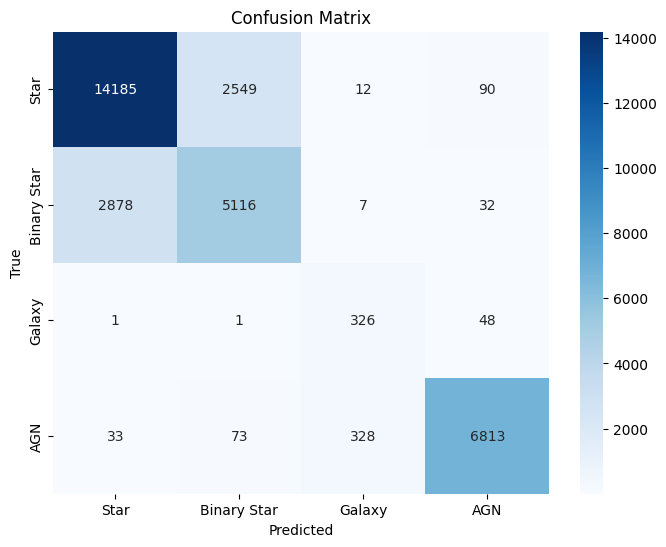

In [16]:
print_confusion_matrix(model, X_val, y_val)

# Deeper dense layer

In [21]:
# Create and train the model
filters=[1024, 512, 512, 512, 512, 512, 256, 256, 256, 256, 256]
model = create_convnet(input_shape, num_classes, num_filters=filters, kernel_size=(9,))

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_87 (Conv1D)              │ (None, 3748, 1024)     │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_87 (MaxPooling1D) │ (None, 1874, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_88 (Conv1D)              │ (None, 1874, 512)      │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_88 (MaxPooling1D) │ (None, 937, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 937, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_89 (Conv1D)              │ (None, 937, 512)       │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_89 (MaxPooling1D) │ (None, 468, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 468, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_90 (Conv1D)              │ (None, 468, 512)       │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_90 (MaxPooling1D) │ (None, 234, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 234, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_91 (Conv1D)              │ (None, 234, 512)       │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_91 (MaxPooling1D) │ (None, 117, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 117, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_92 (Conv1D)              │ (None, 117, 512)       │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_92 (MaxPooling1D) │ (None, 58, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 58, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_93 (Conv1D)              │ (None, 58, 256)        │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_93 (MaxPooling1D) │ (None, 29, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 29, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_94 (Conv1D)              │ (None, 29, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_94 (MaxPooling1D) │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_95 (Conv1D)              │ (None, 14, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_95 (MaxPooling1D) │ (None, 7, 256)         │             

 Total params: 17,994,252 (68.64 MB)

 Trainable params: 17,994,252 (68.64 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
histories = train_convnet_many_times(model, train_generator, val_generator, epochs_per_run=1, num_runs=300)

Training run 1/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 64s 219ms/step - accuracy: 0.2843 - loss: 1.4906 - val_accuracy: 0.2392 - val_loss: 1.3864
Training run 2/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 213ms/step - accuracy: 0.3148 - loss: 1.3849 - val_accuracy: 0.2379 - val_loss: 1.3859
Training run 3/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 232ms/step - accuracy: 0.3074 - loss: 1.3838 - val_accuracy: 0.2404 - val_loss: 1.3867
Training run 4/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - accuracy: 0.2945 - loss: 1.3821 - val_accuracy: 0.2462 - val_loss: 1.3857
Training run 5/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 231ms/step - accuracy: 0.2985 - loss: 1.3818 - val_accuracy: 0.2379 - val_loss: 1.3869
Training run 6/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 232ms/step - accuracy: 0.3087 - loss: 1.3782 - val_accuracy: 0.2768 - val_loss: 1.3838
Training run 7/300...
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accuracy: 0.3162 - loss: 1.3838 - val_accuracy: 0.3374 - val_loss: 1.3818
Traini

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 72s 69ms/step
Confusion Matrix:
[[  714 15875   185    62]
 [  112  7821    74    26]
 [    0     3   373     0]
 [    0    82  7139    26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.04      0.08     16836
           1       0.33      0.97      0.49      8033
           2       0.05      0.99      0.09       376
           3       0.23      0.00      0.01      7247

    accuracy                           0.27     32492
   macro avg       0.37      0.50      0.17     32492
weighted avg       0.58      0.27      0.17     32492



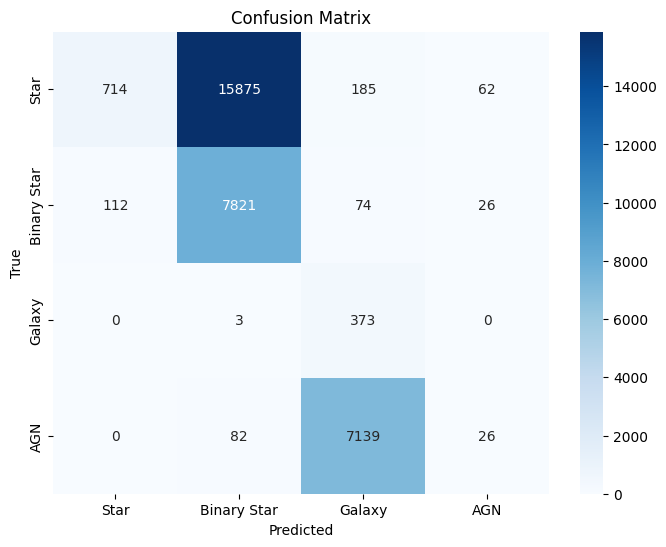

In [23]:
# Print confusion matrix and classification report
print_confusion_matrix(model, X_val, y_val)

# Larger kernel size

In [24]:
filters=[1024, 512, 512, 512, 512, 512, 256, 256, 256, 256, 256]
model = create_convnet(input_shape, num_classes, num_filters=filters, kernel_size=(30,))

/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1016/1016 ━━━━━━━━━━━━━━━━━━━━ 126s 113ms/step
Confusion Matrix:
[[    0     0 16836     0]
 [    0     0  8033     0]
 [    0     0   376     0]
 [    0     0  7247     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16836
           1       0.00      0.00      0.00      8033
           2       0.01      1.00      0.02       376
           3       0.00      0.00      0.00      7247

    accuracy                           0.01     32492
   macro avg       0.00      0.25      0.01     32492
weighted avg       0.00      0.01      0.00     32492



/home/jcwind/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jcwind/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jcwind/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


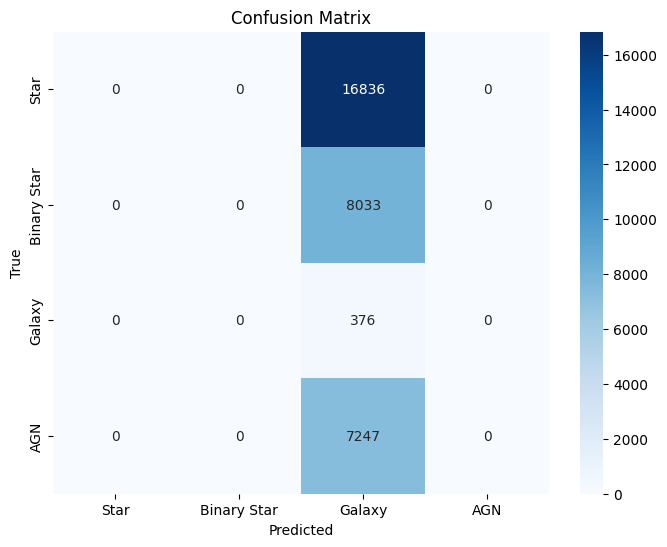

In [25]:
# Print confusion matrix and classification report
print_confusion_matrix(model, X_val, y_val)

# Opposite filter order big kernel

In [26]:
filters=[256, 256, 256, 256, 256, 512, 512, 512, 512, 512, 1024]
model = create_convnet(input_shape, num_classes, num_filters=filters, kernel_size=(30,))

/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1016/1016 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step
Confusion Matrix:
[[16836     0     0     0]
 [ 8033     0     0     0]
 [  376     0     0     0]
 [ 7247     0     0     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68     16836
           1       0.00      0.00      0.00      8033
           2       0.00      0.00      0.00       376
           3       0.00      0.00      0.00      7247

    accuracy                           0.52     32492
   macro avg       0.13      0.25      0.17     32492
weighted avg       0.27      0.52      0.35     32492



/home/jcwind/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jcwind/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jcwind/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


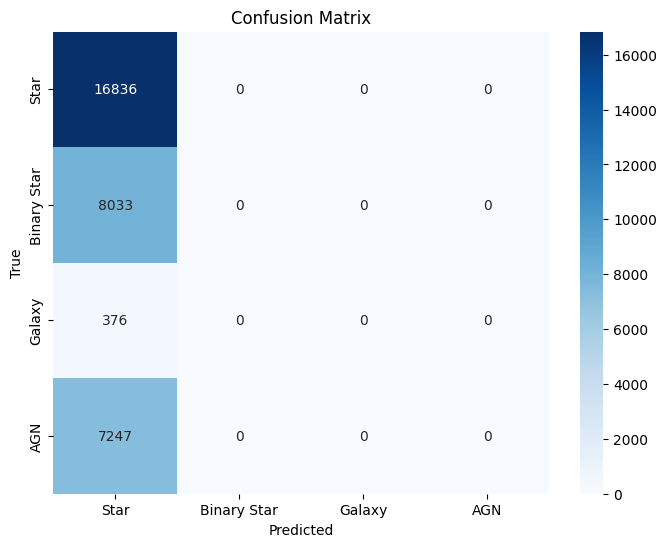

In [27]:
# Print confusion matrix and classification report
print_confusion_matrix(model, X_val, y_val)

# Constant filter number

In [28]:
filters=[442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442]
model = create_convnet(input_shape, num_classes, num_filters=filters, kernel_size=(30,))

/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1016/1016 ━━━━━━━━━━━━━━━━━━━━ 92s 81ms/step
Confusion Matrix:
[[    0 16836     0     0]
 [    0  8033     0     0]
 [    0   376     0     0]
 [    0  7247     0     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16836
           1       0.25      1.00      0.40      8033
           2       0.00      0.00      0.00       376
           3       0.00      0.00      0.00      7247

    accuracy                           0.25     32492
   macro avg       0.06      0.25      0.10     32492
weighted avg       0.06      0.25      0.10     32492



/home/jcwind/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jcwind/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jcwind/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


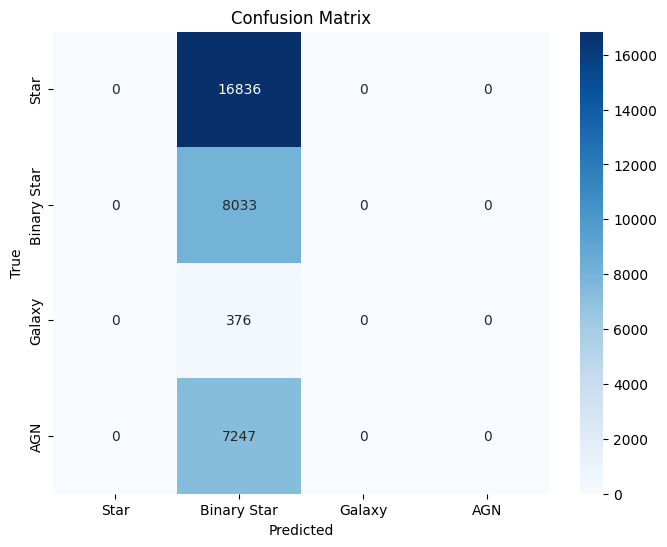

In [29]:
# Print confusion matrix and classification report
print_confusion_matrix(model, X_val, y_val)